# Solving and Simulation

In [196]:
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [197]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [198]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [199]:
# parameters
ρ = 0.05 # discount rate
α = 0.3 # capital elasticity
δ = 0.1 # depreciation
θ = 1.0 # crra param

## Ramsey Model

In [200]:
# algorithm
S0 = 2**16 # max number of steps in perturbation simulation
S1 = 4096 # short simulation
K = 512 # size of capital grid
ptol = 1.0e-4 # initial displacement for perturbation simulation
dt_max = 1.0 # max time step in variable delt schemes

In [201]:
# steady state
k_ss = (α/(ρ+δ))**(1.0/(1.0-α))
i_ss = δ*k_ss
y_ss = k_ss**α
c_ss = y_ss - i_ss

In [202]:
# grid it up
k_lo, k_hi = 0.01, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)

In [203]:
def simulate_ramsey(k0, c0, k_lo=0, k_hi=None, gk_targ=0.001, dt=None, S=S0, direc=-1):
    # initial values
    k, c = k0, c0
    kpath, cpath = [k], [c]

    for t in range(S):
        # growth rates
        gk = k**(α-1) - δ - c/k
        gc = (1/θ)*(α*k**(α-1)-(ρ+δ))

        # adaptive step size
        dt1 = direc*np.minimum(dt_max, gk_targ/np.abs(gk)) if dt is None else dt
        k *= 1 + dt1*gk
        c *= 1 + dt1*gc

        # store
        kpath.append(k)
        cpath.append(c)

        # terminal condition
        if k_lo is not None and k <= k_lo:
            break
        if k_hi is not None and k >= k_hi:
            break

    return np.array(kpath), np.array(cpath)

In [204]:
# generate upper and lower paths
kvec1, cvec1 = simulate_ramsey(k_ss-ptol, c_ss-ptol, k_lo, k_hi)
kvec2, cvec2 = simulate_ramsey(k_ss+ptol, c_ss+ptol, k_lo, k_hi)

# combined path
kvec = np.concatenate([kvec1[::-1], kvec2])
cvec = np.concatenate([cvec1[::-1], cvec2])

# interpolate
cpol = interp.interp1d(kvec, cvec)

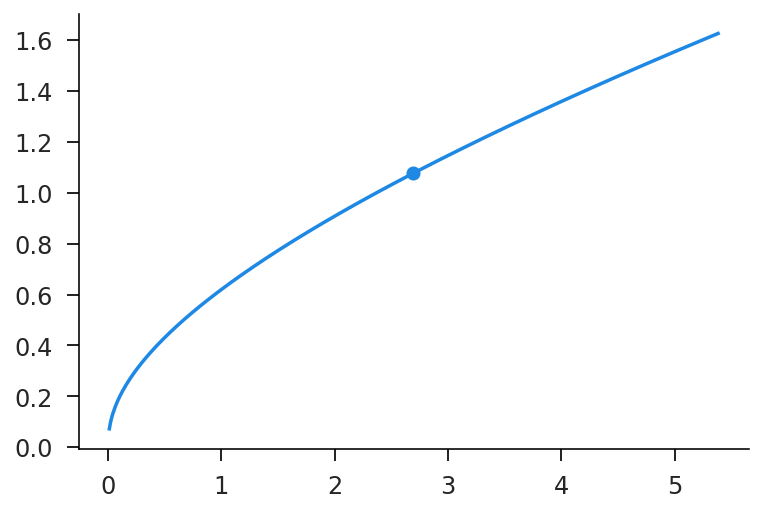

In [205]:
c_grid = cpol(k_grid)

# plot results
fig, ax = plt.subplots()
ax.plot(k_grid, c_grid);
# ax.scatter(kvec, cvec);
ax.scatter([k_ss], [c_ss]);

In [206]:
def forward_ramsey(k0, cf, dt=0.01, S=S0):
    # initial values
    k, c = k0, cf(k0)
    kpath, cpath = [k], [c]

    for t in range(S):
        gk = k**(α-1) - δ - c/k

        k *= 1 + dt*gk
        c = cf(k)

        # store
        kpath.append(k)
        cpath.append(c)

    return np.array(kpath), np.array(cpath)

In [207]:
def solow_policy(s):
    return lambda k: (1-s)*k**α

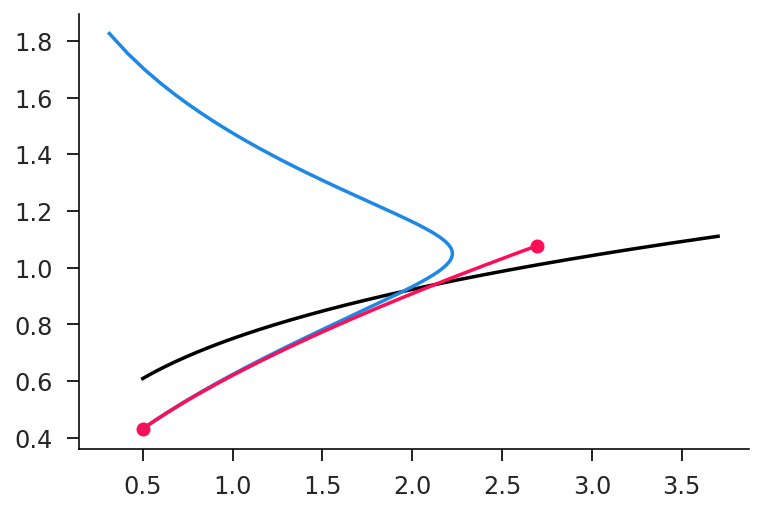

In [225]:
k0 = 0.5
c0 = float(cpol(k0))

csol = solow_policy(0.25)

dt = 0.1
kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
ksol, csol = forward_ramsey(k0, csol, dt=dt, S=S1)
ksim, csim = simulate_ramsey(k0, c0, dt=dt, k_lo=0.4, direc=1)

fig, ax = plt.subplots()
ax.plot(ksol, csol, color='k');
ax.plot(ksim, csim, color=col[0]);
ax.plot(kfwd, cfwd, color=col[1]);
ax.scatter([k0, k_ss], [c0, c_ss], color=col[1]);

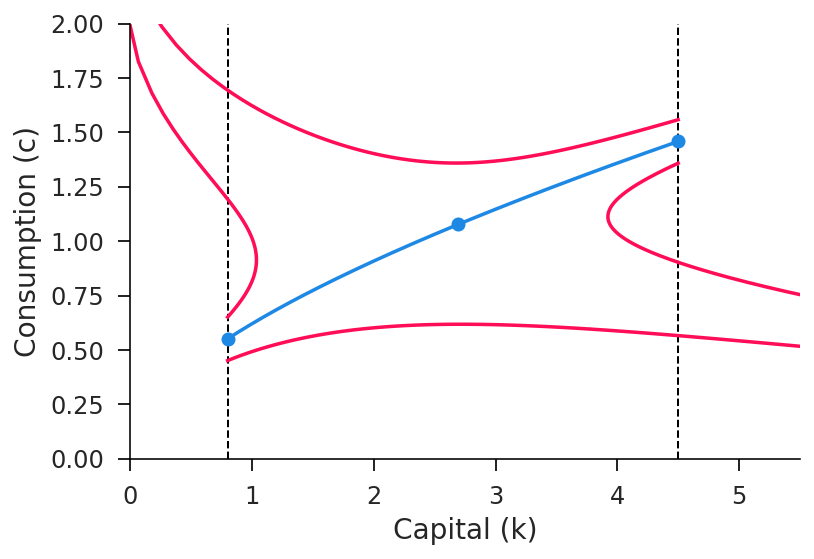

In [227]:
kv0 = [0.8, 4.5]
cv0 = cpol(kv0)
dt = 0.1
err = 0.1

fig, ax = plt.subplots()

for k0, c0 in zip(kv0, cv0):
    kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
    ksim1, csim1 = simulate_ramsey(k0, c0-err, dt=dt, k_hi=6.0, S=S1, direc=1)
    ksim2, csim2 = simulate_ramsey(k0, c0+err, dt=dt, k_hi=6.0, S=S1, direc=1)

    ax.plot(kfwd, cfwd, color=col[0]);
    ax.plot(ksim1, csim1, color=col[1]);
    ax.plot(ksim2, csim2, color=col[1]);
    ax.vlines(k0, 0, 2, color='k', linestyle='--', linewidth=1);
    
ax.scatter(kv0, cv0, color=col[0], zorder=3);
ax.scatter([k_ss], [c_ss], color=col[0], zorder=3);

ax.set_xlim(0, 5.5);
ax.set_ylim(0, 2);

ax.set_xlabel('Capital (k)');
ax.set_ylabel('Consumption (c)');

## Exercise

1. Simulate a pre-announced policy change, such as a capital gains tax.

## JAX Basics

In [19]:
import jax
import jax.numpy as npx
from jax import lax
import numpy as np0

In [80]:
xs = 3.0
xs

3.0

In [82]:
xv = np.linspace(1.0, 5.0, 5)
xv

array([1., 2., 3., 4., 5.])

#### Scalar

In [85]:
def f(x):
    return x**2
f(xs)

9.0

In [87]:
g = lambda x: x**2
g(xs)

9.0

In [88]:
df = jax.grad(f)
df(xs)

DeviceArray(6., dtype=float32)

In [89]:
d2f = jax.grad(df)
d2f(xs)

DeviceArray(2., dtype=float32)

#### Vector

In [97]:
def fv(x):
    return npx.sum(x**2) + x[1]*x[3]
fv(xv)

DeviceArray(63., dtype=float32)

In [98]:
dfv = jax.grad(fv)
dfv(xv)

DeviceArray([ 2.,  8.,  6., 10., 10.], dtype=float32)

In [99]:
hfv = jax.jacobian(dfv)
hfv(xv)

DeviceArray([[2., 0., 0., 0., 0.],
             [0., 2., 0., 1., 0.],
             [0., 0., 2., 0., 0.],
             [0., 1., 0., 2., 0.],
             [0., 0., 0., 0., 2.]], dtype=float32)

#### vmap

In [100]:
fv2 = jax.vmap(f)
fv2(xv)

DeviceArray([ 1.,  4.,  9., 16., 25.], dtype=float32)

In [101]:
dfv2 = jax.grad(lambda x: npx.sum(fv2(x)))
dfv2(xv)

DeviceArray([ 2.,  4.,  6.,  8., 10.], dtype=float32)

#### JIT

In [108]:
jdfv = jax.jit(dfv)
jdfv(xv)

DeviceArray([ 2.,  8.,  6., 10., 10.], dtype=float32)

In [109]:
xv2 = np.linspace(1.0, 5.0, 100000)

In [112]:
%timeit -n 100 dfv(xv2)

7.97 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [113]:
%timeit -n 100 jdfv(xv2)

209 µs ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Trees

In [114]:
xd = {
    'x': np.linspace(1.0, 5.0, 5),
    'y': np.linspace(10.0, 19.0, 10),
}
xd

{'x': array([1., 2., 3., 4., 5.]),
 'y': array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])}

In [116]:
def ft(d):
    xsum = npx.sum(d['x']**3)
    ysum = npx.sum(d['y']**2)
    return xsum + ysum

In [117]:
dft = jax.grad(ft)
dft(xd)

{'x': DeviceArray([ 3., 12., 27., 48., 75.], dtype=float32),
 'y': DeviceArray([20., 22., 24., 26., 28., 30., 32., 34., 36., 38.], dtype=float32)}

#### Partial

In [118]:
def fa(x, α):
    return np.sum(x**α)

In [120]:
fa2 = jax.partial(fa, α=2)
dfa2 = jax.grad(fa2)
dfa2(xv)

DeviceArray([ 2.,  4.,  6.,  8., 10.], dtype=float32)

## Optimization with JAX

### Simple Function

In [85]:
Δ = 0.1

In [86]:
# simple function
f = lambda x: -(x-1)**2 + 1
df = jax.grad(f)
vdf = jax.vmap(df)

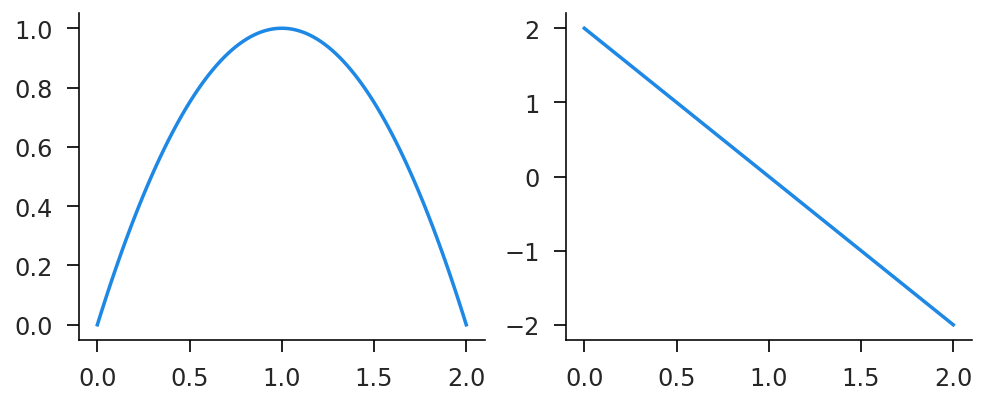

In [87]:
xgrid = npx.linspace(0, 2, 100)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.plot(xgrid, f(xgrid))
ax1.plot(xgrid, vdf(xgrid));

In [92]:
def update_scalar(x, t):
    xp = x + Δ*df(x)
    return xp, xp

def maximize_func(x0, K=50):
    tvec = np.arange(K)
    x1, xvec = lax.scan(update_scalar, x0, tvec)
    return x1, xvec

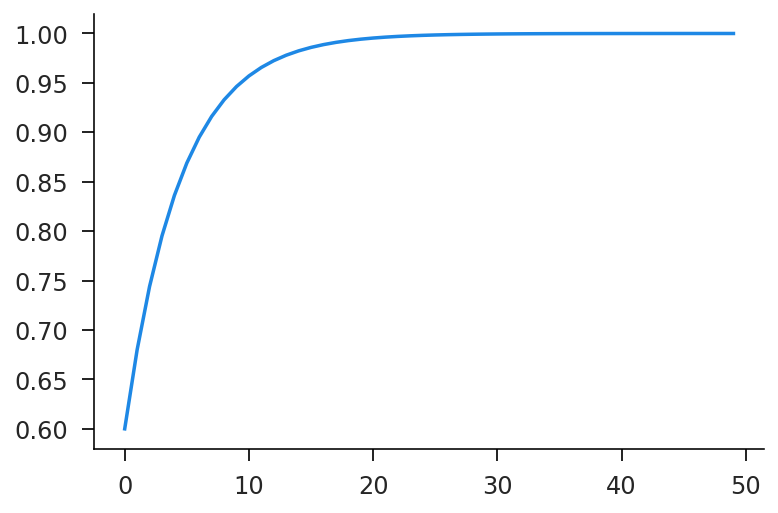

In [93]:
x1, xvec = maximize_func(0.5)
plt.plot(xvec);

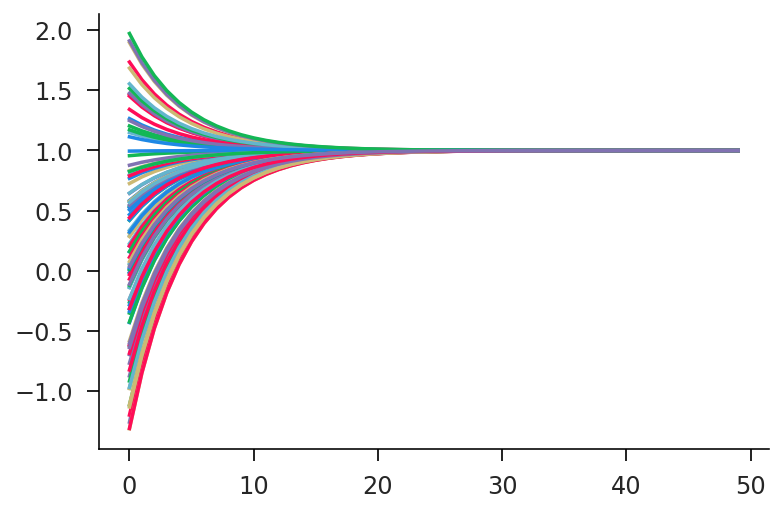

In [94]:
vmax_func = jax.vmap(maximize_func)
key = jax.random.PRNGKey(42)
xrand = jax.random.normal(key, (100,))
x1, xvec = vmax_func(xrand)
plt.plot(xvec.T);

### Parameterized

In [189]:
# parameter function
f1 = lambda x, α: -(x-α)**2
df1 = jax.grad(f1)
vdf1 = jax.vmap(df1)

In [190]:
def update_scalar(α, x, t):
    xp = x + Δ*df1(x, α)
    return xp, xp

def maximize_func(α, x0, K=50):
    tvec = np.arange(K)
    upd = lambda x, t: update_scalar(α, x, t)
    x1, xvec = lax.scan(upd, x0, tvec)
    return x1, xvec

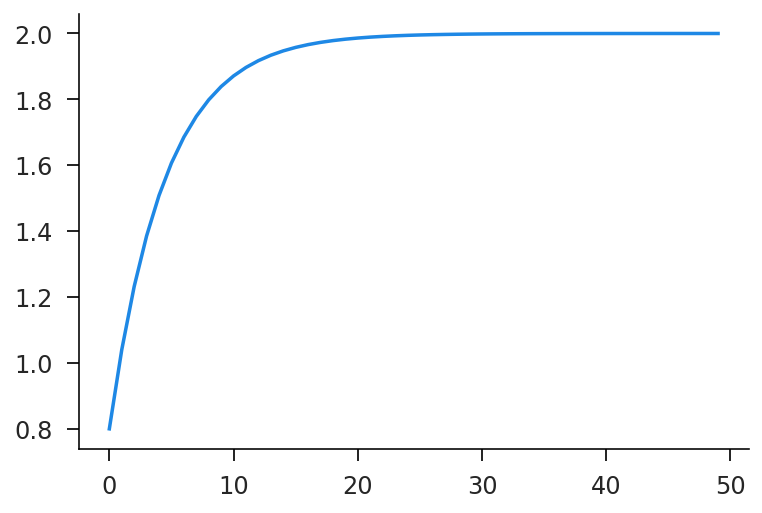

In [191]:
x1, xvec = maximize_func(2.0, 0.5)
plt.plot(xvec);

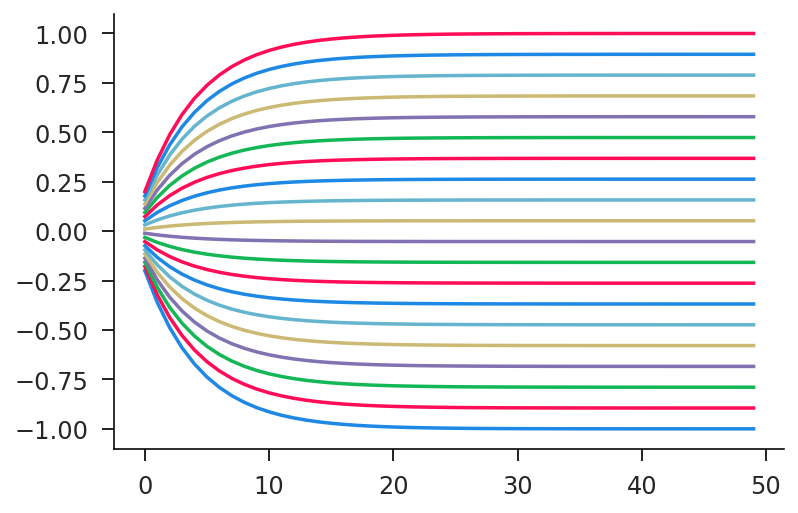

In [192]:
vmax_func = jax.vmap(maximize_func, in_axes=[0, None])
αgrid = npx.linspace(-1, 1, 20)
x1, xvec = vmax_func(αgrid, 0.0)
plt.plot(xvec.T);

In [193]:
fmax_func = lambda α: maximize_func(α, 0.0)[0]
dmax_func = jax.grad(fmax_func)
vdmax_func = jax.vmap(dmax_func)

In [194]:
dmax_func(2.0)

DeviceArray(0.99998564, dtype=float32)

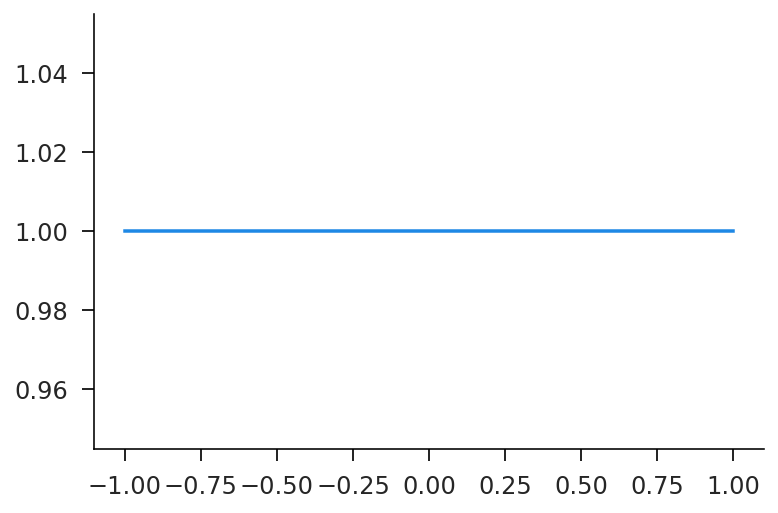

In [195]:
plt.plot(αgrid, vdmax_func(αgrid));

## Value Functions with JAX

In [121]:
from jax import lax

In [122]:
# fixed params
T = 300 # time periods
N = 100 # grid size
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [123]:
# simple parameters
par0 = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

In [124]:
# find steady state
def get_kss(par):
    β, δ, z, α = par['β'], par['δ'], par['z'], par['α']
    rhs = (1-β)/β + δ
    k = (α*z/rhs)**(1/(1-α))
    return k
k_ss = get_kss(par0)

In [125]:
# construct capital grid
k_min = f_lo*k_ss
k_max = f_hi*k_ss
k_grid = npx.linspace(k_min, k_max, N)

In [126]:
# defined functions
def util(c, eps=1e-6):
    c1 = npx.maximum(eps, c)
    return npx.log(c1)
def prod(k, z, α):
    return z*k**α

In [127]:
def value(par, grid, st, tv):
    β = par['β']
    cp = grid['cp']
    vn = st['vn']

    # calculate optimal investment
    vp = util(cp) + β*vn[None,:]
    ip = npx.argmax(vp, axis=1)
    vp = npx.max(vp, axis=-1)

    # apply at values
    kp = k_grid[ip]
    
    # compute update errors
    err = npx.max(npx.abs(vp-vn))

    # return state and output
    stp = {
        'vn': vp,
    }    
    out = {
        'v': vp,
        'kp': kp,
        'err': err,
    }
    
    return stp, out

In [129]:
def solve(par, T):
    α = par['α']
    δ = par['δ']
    z = par['z']

    # precompute grid values
    y_grid = prod(k_grid, z, α)
    yd_grid = y_grid + (1-δ)*k_grid
    cp_grid = yd_grid[:,None] - k_grid[None,:]

    # partially apply grid
    grid = {
        'cp': cp_grid,
    }
    value1 = jax.partial(value, par, grid)

    # scan over time (backwards)
    st0 = {
        'vn': util(y_grid),
    }
    tv = {
        't': npx.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

In [130]:
jsolve = jax.jit(solve, static_argnums=(1,))

In [133]:
ret = jsolve(par0, T)

In [136]:
%timeit -r 10 -n 10 jsolve(par0, T)

8.04 ms ± 1.09 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


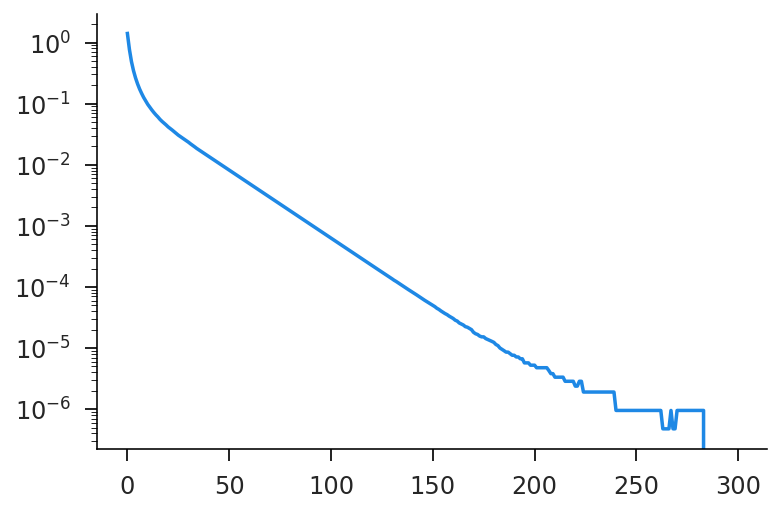

In [137]:
plt.plot(ret['err'])
plt.yscale('log');

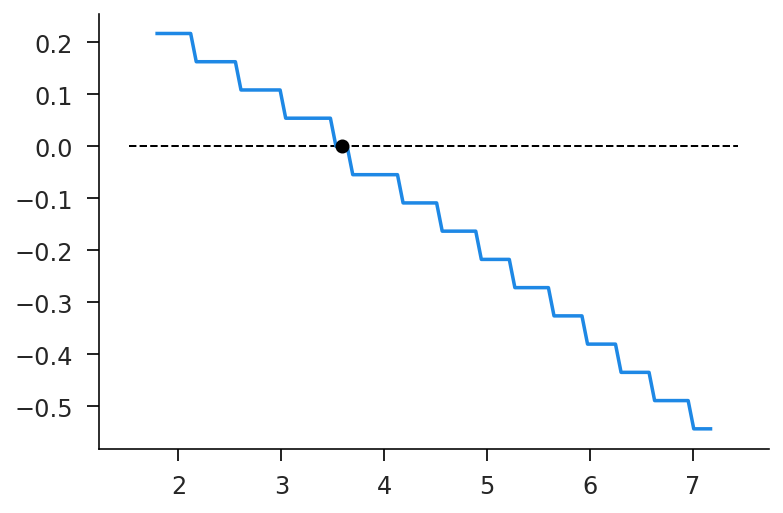

In [138]:
fig, ax = plt.subplots()
ax.plot(k_grid, ret['kp'][-1, :]-k_grid);
ax.hlines(0, *ax.get_xlim(), linestyle='--', linewidth=1, color='k')
ax.scatter(k_ss, 0, color='k', zorder=10);

## Exercise

1. Redo the Ramsey path finding with JAX
2. Smooth out the policy function using interpolation